In [4481]:
from sympy import init_session
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.integrate as it
from scipy.signal import savgol_filter


init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [4482]:
# Size
a = 1.97 * 0.0254 #m R2
b = 12.4 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1
a, b, c, d

In [4483]:
m = 3.78 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/12 * m * l**2 + m * (l/2)**2 + 1/3 * m * l**2#moment of inertia about com kgm^2
mu_k = 0.3  # coefficient of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 25 #degs
n = 3 # order of polynomial filtering 
b = 61 # window size for filter need to be odd number
I

In [4484]:
#Parameters
motor_torque = 30 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["time [s]", "theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_43 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])
#df.head(20)
#print(df.shape[0])
results = motor_torque * ((c * np.sin(np.deg2rad(156.133)))/ (a * np.sin(np.deg2rad(0.33))))
results2 = motor_torque * ((c * np.sin(np.deg2rad(156.133)))/ (a))
print(results2)

19.532427143362487


In [4485]:
#Torque Calculations

tau_out = []
err = 15 # to eliminate spikes and use small angle approximation
for i in range(df.shape[0]):
    theta_a = 180.0 - df["theta_2 [°]"][i] + df["theta_3 [°]"][i] # inner angle between link a and b
    theta_b = df["theta_4 [°]"][i]- df["theta_3 [°]"][i] # inner angle between link b and c
    if abs(theta_a) > err and abs(theta_a) < (180-err):
        #print("good")
        temp1 = motor_torque * ((c * np.sin(np.deg2rad(theta_b)))/ (a * np.sin(np.deg2rad(theta_a))))
        tau_out.append(temp1)
    elif abs(theta_b) < err and abs(theta_a) > (180-err):
        temp2 = motor_torque * (c)/ (a)
        tau_out.append(temp2)
    else: 
        #print("anti bug")
        temp3 = motor_torque * (c * np.sin(np.deg2rad(theta_b)))/ (a)
        tau_out.append(temp3)

filter_tau_out = savgol_filter(tau_out, b, n)
df["Input_Torque [nm]"] = filter_tau_out
(print(df["Input_Torque [nm]"].to_string()))

0     -46.235608
1     -50.320334
2     -53.687491
3     -56.365557
4     -58.383008
5     -59.768323
6     -60.549979
7     -60.756452
8     -60.416221
9     -59.557762
10    -58.209554
11    -56.400073
12    -54.157797
13    -51.511202
14    -48.488768
15    -45.118970
16    -41.430287
17    -37.451195
18    -33.210173
19    -28.735696
20    -24.056244
21    -19.200292
22    -14.196319
23     -9.072802
24     -3.858218
25      1.418955
26      6.730240
27     12.047160
28     17.341237
29     22.583994
30     27.746954
31     31.473632
32     35.050607
33     38.472360
34     41.714257
35     44.743767
36     47.513972
37     49.949566
38     53.553529
39     56.857121
40     59.836674
41     62.468097
42     64.727130
43     66.589364
44     68.029894
45     69.022545
46     69.538658
47     72.095681
48     73.520482
49     73.858051
50     73.107912
51     71.229434
52     68.135909
53     63.674617
54     57.579380
55     55.068748
56     52.197513
57     48.989815
58     45.4686

In [4486]:
# Equations of Motion
acceleration_t = []
force_spring = []
alpha_w = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = (df["Input_Torque [nm]"][i]- m * g * np.cos(np.radians(theta)))/ I  #alpha
    alpha_w.append(temp7)
    
    temp8 = l * alpha_w[i] #use a = r*alpha to find tangential acceleration
    acceleration_t.append(temp8)
    
    temp9 = l * (df["Input_Torque [nm]"][i]) + m * acceleration_t[i] #friction
    F_friction.append(temp8)

    temp10 = F_friction[i] / mu_k #Normal force
    F_n.append(temp10)
    
    temp11 = F_n[i] - m * g * np.cos(np.radians(theta)) #Spring Force
    force_spring.append(temp11)
    
df["F_normal [N]"] = F_n
df["Friction [N]"] = F_friction
df["acc_tan [m/s^2]"] = acceleration_t
df["alpha_w [rad/s^2]"] = alpha_w
df["F_spring [N]"]= force_spring
df.head()

,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],alpha_2 [rad/s^2],alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_Torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N]
0,0.00,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,-46.235608,-169.713334,-50.914000,-50.914000,-81.815845,-203.320858
1,0.01,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,-50.320334,-178.395766,-53.518730,-53.518730,-86.001494,-212.003290
2,0.02,4.780489,0.380609,2.156869,273.901843,21.807267,123.579504,6.81,0.547185,-4.113627,0.0,-11.020230,-4.328158,-53.687491,-185.552944,-55.665883,-55.665883,-89.451845,-219.160468
3,0.03,4.848589,0.385524,2.115527,277.803685,22.088886,121.210765,6.81,0.435307,-4.153755,0.0,-11.345834,-3.681429,-56.365557,-191.245399,-57.373620,-57.373620,-92.196079,-224.852923
4,0.04,4.916689,0.389305,2.073817,281.705528,22.305527,118.820983,6.81,0.320474,-4.186905,0.0,-11.609664,-2.929573,-58.383008,-195.533663,-58.660099,-58.660099,-94.263376,-229.141187


In [4487]:
#Use trapezoidal rule to find v by integration
dt = 0.01
v_tan = it.cumulative_trapezoid(y = df["acc_tan [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
#v_nor = it.cumulative_trapezoid(y = df["acc_nor [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
df["vel_tan [m/s]"] = v_tan
#df["vel_nor [m/s]"] = v_nor


In [4488]:
#Use trapezoidal rule to find position by integration
dt = 0.01
tan = it.cumulative_trapezoid(y = df["vel_tan [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
#nor = it.cumulative_trapezoid(y = df["vel_nor [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
df["pos_tan [m]"] = tan
#df["pos_nor [m]"] = nor

In [4489]:
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],...,alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_Torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N],vel_tan [m/s],pos_tan [m]
0,0.00,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,...,-10.640384,-4.887655,-46.235608,-169.713334,-50.914000,-50.914000,-81.815845,-203.320858,0.000000,0.000000
1,0.01,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,...,-10.640384,-4.887655,-50.320334,-178.395766,-53.518730,-53.518730,-86.001494,-212.003290,-0.522164,-0.002611
2,0.02,4.780489,0.380609,2.156869,273.901843,21.807267,123.579504,6.81,0.547185,-4.113627,...,-11.020230,-4.328158,-53.687491,-185.552944,-55.665883,-55.665883,-89.451845,-219.160468,-1.068087,-0.010562
3,0.03,4.848589,0.385524,2.115527,277.803685,22.088886,121.210765,6.81,0.435307,-4.153755,...,-11.345834,-3.681429,-56.365557,-191.245399,-57.373620,-57.373620,-92.196079,-224.852923,-1.633284,-0.024069
4,0.04,4.916689,0.389305,2.073817,281.705528,22.305527,118.820983,6.81,0.320474,-4.186905,...,-11.609664,-2.929573,-58.383008,-195.533663,-58.660099,-58.660099,-94.263376,-229.141187,-2.213453,-0.043303


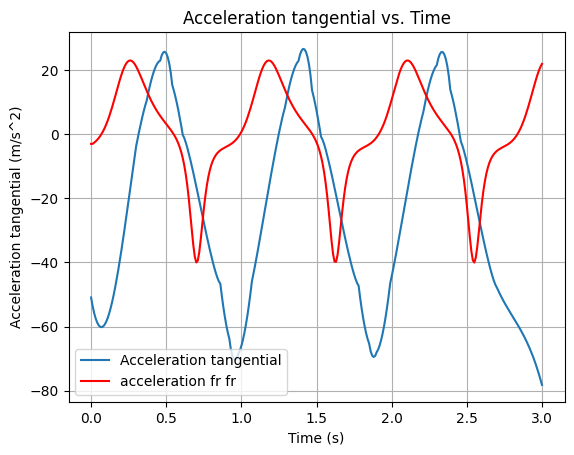

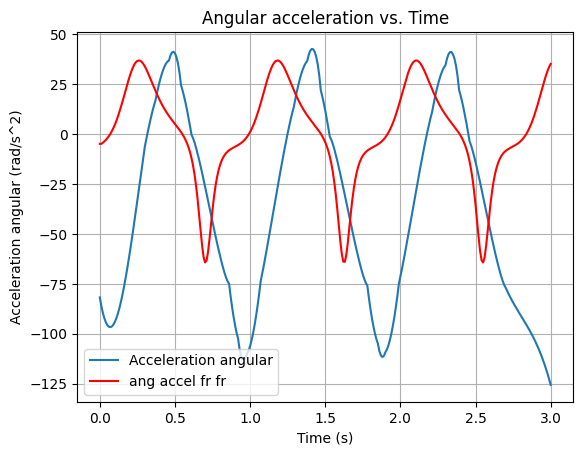

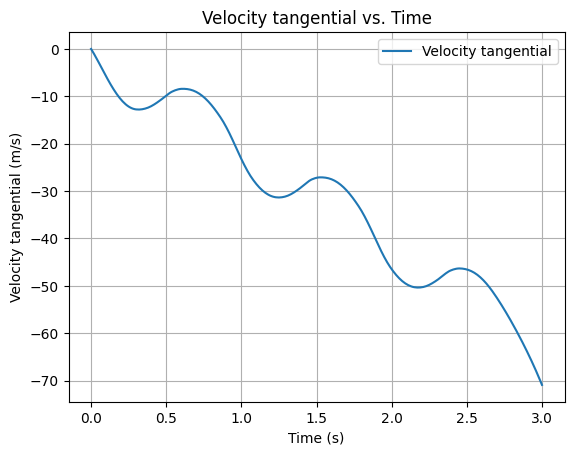

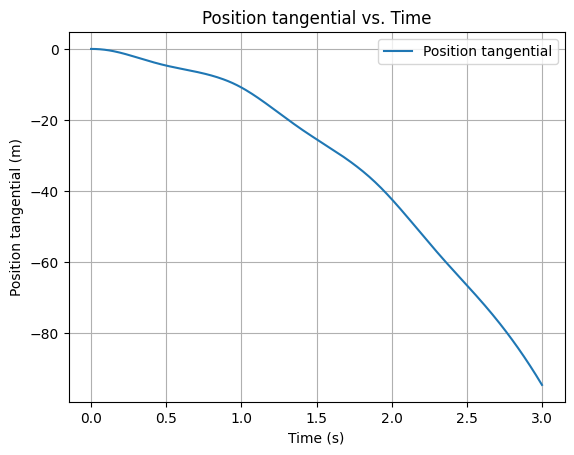

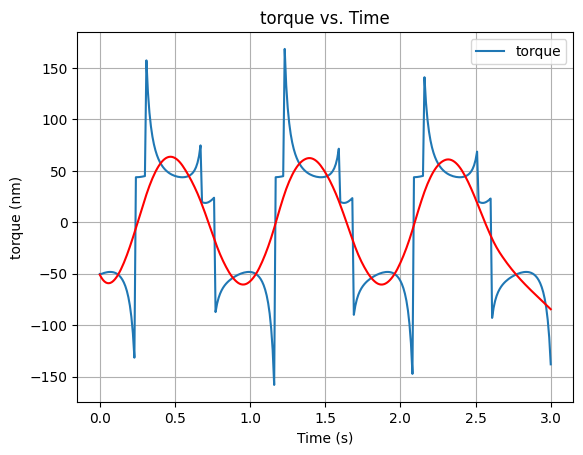

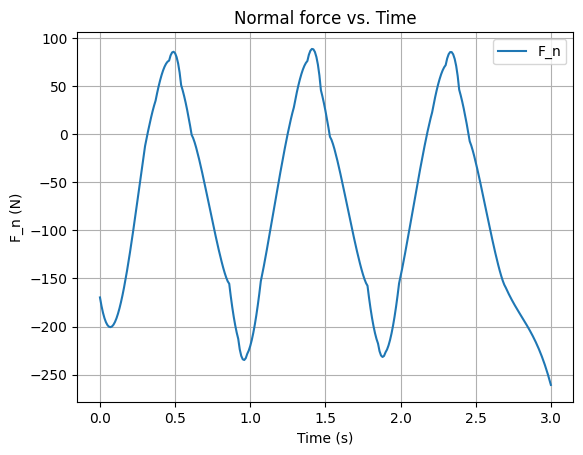

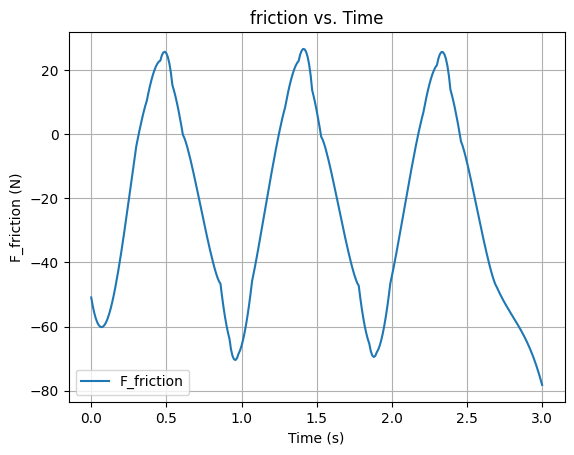

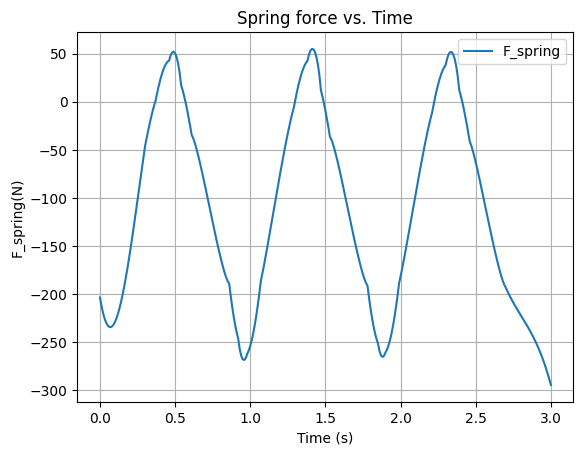

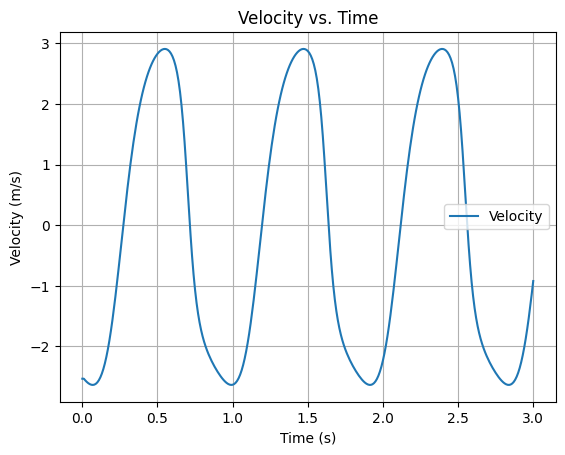

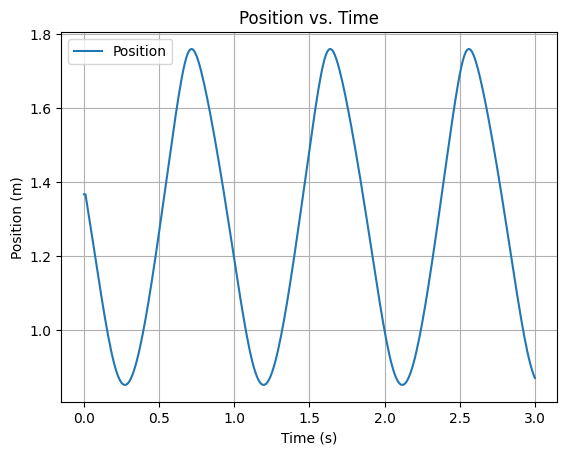

In [4490]:
# Plotting the graphs

plt.plot(df["time [s]"], df["acc_tan [m/s^2]"], label='Acceleration tangential')
plt.plot(df["time [s]"], l * df["alpha_4 [rad/s^2]"], label='acceleration fr fr', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration tangential (m/s^2)')
plt.title('Acceleration tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["alpha_w [rad/s^2]"], label='Acceleration angular')
plt.plot(df["time [s]"], df["alpha_4 [rad/s^2]"], label='ang accel fr fr ', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration angular (rad/s^2)')
plt.title('Angular acceleration vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["vel_tan [m/s]"] , label='Velocity tangential')
plt.xlabel('Time (s)')
plt.ylabel('Velocity tangential (m/s)')
plt.title('Velocity tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_tan [m]"] , label='Position tangential')
plt.xlabel('Time (s)')
plt.ylabel('Position tangential (m)')
plt.title('Position tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], tau_out, label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')
plt.legend()
plt.grid()
yhat = savgol_filter(df["Input_Torque [nm]"], b, n) # window size b, polynomial order n
plt.plot(df["time [s]"],yhat, color = 'red')
plt.show()


plt.plot(df["time [s]"], df["F_normal [N]"], label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["Friction [N]"], label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_spring [N]"], label='F_spring')
plt.xlabel('Time (s)')
plt.ylabel('F_spring(N)')
plt.title('Spring force vs. Time')
plt.legend()
plt.grid()
plt.show()



plt.plot(df["time [s]"], l * df["omega_4 [rad/s]"], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["theta_4 [rad]"], label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs. Time')
plt.legend()
plt.grid()
plt.show()